# Total Number of Iterations

## Setup and loading datasets

In [61]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures
import styles

In [2]:
def load_all_datasets(): 
    """This function loads: Iris, Mouse Retina, MNIST and flow18 datasets"""
    all_datasets = [None] * 4

    all_datasets[0] = datasets.load_iris_data()
    all_datasets[1] = datasets.load_mouse_retina()
    all_datasets[2] = datasets.load_mnist()
    all_datasets[3] = datasets.load_flow18()

    return all_datasets

In [3]:
all_data = load_all_datasets()

/Users/soli/Desktop/uni/thesis/code/scripts/datasets.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["class"] = df_filtered["class"].map(class_mapping)


## Functions for Running and Plotting

### KLD Monitoring

In [4]:
from openTSNE import callbacks

class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error


### Running t-SNE (returns embedding dict)

In [5]:
def run_tsne_with_callbacks(datasets, iteration_lengths, verbose=False): 
    """Returns embedding dictionary with keys given by iteration length and dataset used to generate the embedding."""
  
    embedding_dict = {}
    for T in tqdm(iteration_lengths): 
        for i, dataset in enumerate(datasets): 
            data, labels = dataset
            # convert to np array (from dataframe) 
            if hasattr(data, "values"):
                data = data.values.astype(np.float64)
                
            kld_monitor = KLDMonitor()
            tsne = TSNE(early_exaggeration_iter=int(T/4), n_iter=T, n_jobs=-1, callbacks=kld_monitor, callbacks_every_iters=5, random_state=42, verbose=verbose)
            embedding = tsne.fit(data)
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(T, i)] = (embedding, labels, kld_values)
    
    return embedding_dict 

In [62]:
import time
import json

def run_tsne_with_callbacks_and_timing(datasets, iteration_lengths, verbose=False, filename="n_iter_times.json"):
    """Returns embedding dictionary with keys given by iteration length and dataset used to generate the embedding.
    
    Also tracks and saves the time taken for each embedding run to a JSON file.
    
    Parameters:
    - datasets: list of tuples (data, labels)
    - iteration_lengths: list of iteration counts for t-SNE (e.g., [250, 500, 1000])
    - verbose (bool): If True, prints additional TSNE information.
    - save_times_path (str): File path to automatically save the time tracking data.
    
    Returns:
    - embedding_dict: dictionary with keys (T, dataset_index) mapping to (embedding, labels, kld_values)
    """
    embedding_dict = {}
    timings = []  # List to store timing information for each embedding

    save_times_path = os.path.join(results_dir, filename)

    for T in tqdm(iteration_lengths):
        for i, dataset in enumerate(datasets):
            data, labels = dataset
            # Convert to np.array if data is a DataFrame
            if hasattr(data, "values"):
                data = data.values.astype(float)
            
            kld_monitor = KLDMonitor()
            tsne = TSNE(early_exaggeration_iter=int(T/4), n_iter=T, n_jobs=-1,
                        callbacks=kld_monitor, callbacks_every_iters=5,
                        random_state=42, verbose=verbose)
            
            start_time = time.time()
            embedding = tsne.fit(data)
            elapsed_time = time.time() - start_time
            
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(T, i)] = (embedding, labels, kld_values)
            
            # Record timing data for this embedding
            timings.append({
                "iterations": T,
                "dataset_index": i,
                "time_taken_seconds": elapsed_time
            })

    # Automatically save the timing information to the specified JSON file.
    with open(save_times_path, "w") as f:
        json.dump(timings, f, indent=4)
    
    return embedding_dict


## Running Experiments

In [6]:
iteration_lengths = [100, 750, 1500, 3000]

In [45]:
def load_n_samples(n_samples, X, y, seed=42):
    if len(y) > n_samples: 
        X_sample = X.sample(n_samples, random_state=seed).reset_index(drop=True)
        y_sample = y.sample(n_samples, random_state=seed).reset_index(drop=True) 
    else: 
        X_sample = X
        y_sample = y
    return X_sample, y_sample

In [63]:
# for testing a smaller number of datapoints 
n_points = 100
datasets_small = [load_n_samples(n_points, X, y) for (X, y) in all_data]

In [64]:
embedding_dict_small = run_tsne_with_callbacks_and_timing(datasets_small, iteration_lengths, verbose=False)

100%|██████████| 4/4 [01:03<00:00, 15.92s/it]


### plotting functions (which should be in plotting.py in the end)

In [65]:
def plot_embedding_grid(embeddings, row_parameter, column_parameter, row_string="", column_string=""):
    """
    Plots a grid of t-SNE embeddings with a common column label.

    Parameters:
    - embeddings (dict): Keys are (col_value, row_value) tuples, and values are (embedding_array, labels, kld_values).
    - row_parameter (list): Values for rows (e.g., datasets [0, 1, 2, 3]).
    - column_parameter (list): Values for columns (e.g., number of iterations, perplexity, etc.).
    - row_string (str): Label for the row axis.
    - column_string (str): Common label for the column axis (displayed once over the grid).
    """
    num_rows = len(row_parameter)
    num_cols = len(column_parameter)
    
    # Choose a subplot side length (in inches) so that each scatterplot is square
    subplot_size = 3  # adjust as needed
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(num_cols * subplot_size, num_rows * subplot_size), 
                             squeeze=False)
    
    # Add a common column label above the grid using fig.text (or you could use fig.suptitle)
    fig.text(0.5, 0.97, column_string, ha='center', va='center', fontsize=14)
    
    # Plot embeddings in each subplot
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]
            
            # Unpack; kld_values is ignored here.
            embedding, labels, _ = embeddings[(col_value, row_value)]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=2)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Remove axis outlines
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # Force the subplot to be square
            # ax.set_aspect('equal', 'box')
            
            # For the top row, display just the column value as the individual title
            if row_idx == 0:
                ax.set_title(f"{col_value}", fontsize=12, pad=10)
            
            # Optionally, add row labels on the left-most column
            if col_idx == 0 and row_string:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)
    
    # Adjust layout to make room for the common column label
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)

    # Save the figure to the specific folder
    save_path = os.path.join(figures_dir, "embedding_grid_test.png")
    plt.savefig(save_path, bbox_inches="tight")

    plt.show()


### running the plots

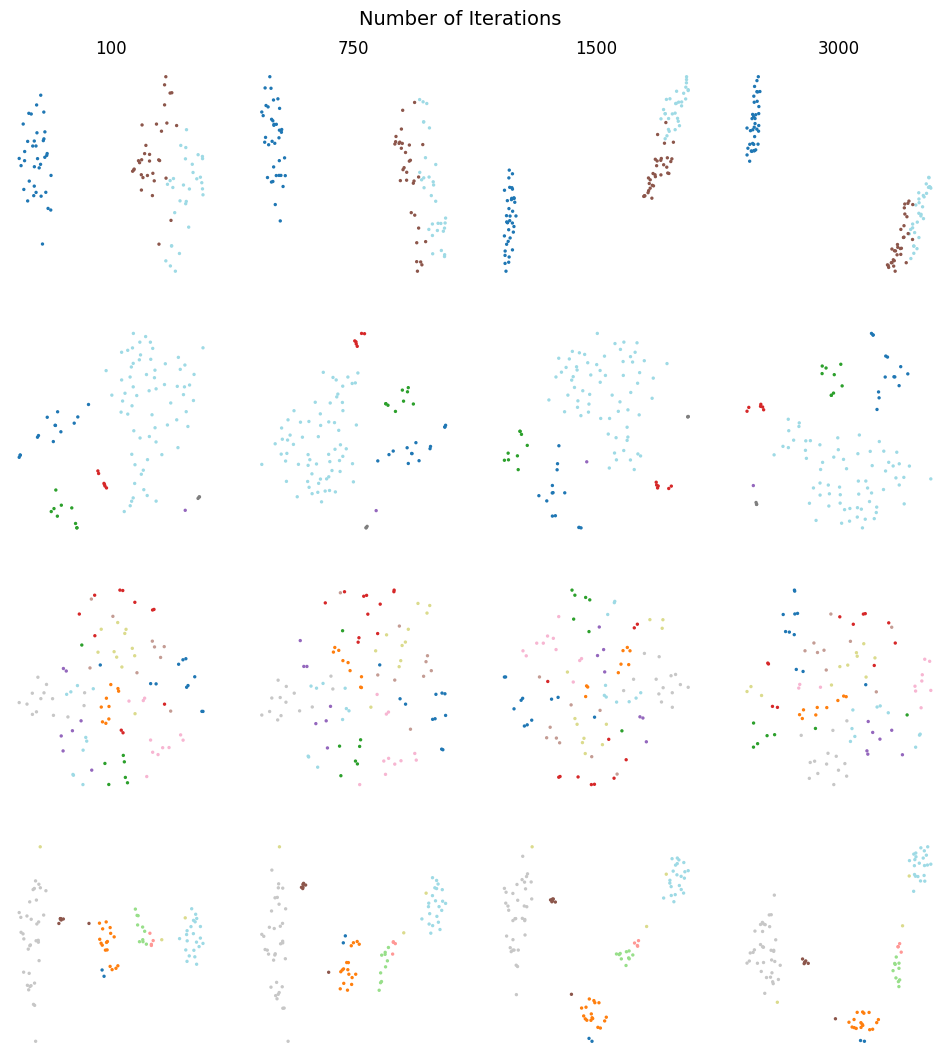

In [66]:
plot_embedding_grid(embedding_dict_small, row_parameter=[0,1,2,3], column_parameter=iteration_lengths, row_string="", column_string="Number of Iterations")

## Measuring Embedding Quality